## CAPTUM

### Model v1

In [1]:
import torch
import torch.nn as nn

import pandas as pd
import h5py
import torch
import numpy as np
import shap
import wandb
import os

# class ResidualBlock(nn.Module):
#     def __init__(self, hidden_dim, dropout):
#         super(ResidualBlock, self).__init__()
#         self.block = nn.Sequential(
#             nn.BatchNorm1d(hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, hidden_dim)
#         )
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            ResidualBlock(input_dim, dropout),
            nn.Linear(input_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(AttentionBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        attn_output, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

class LazyTCR_Epitope_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, tcr_embeddings, epitope_embeddings):
        """
        Args:
            data_frame (DataFrame): The DataFrame containing sample data.
            tcr_embeddings (h5py.File): HDF5 file containing TCR embeddings.
            epitope_embeddings (h5py.File): HDF5 file containing epitope embeddings.
        """
        self.data_frame = data_frame
        self.tcr_embeddings = tcr_embeddings
        self.epitope_embeddings = epitope_embeddings

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]
        tcr_id = sample['TRB_CDR3']  # Column name for TCR IDs
        epitope_id = sample['Epitope']  # Column name for epitope IDs
        label = sample['Binding']  # Target label

        # Access embeddings lazily
        tcr_embedding = self.tcr_embeddings[tcr_id][:]
        epitope_embedding = self.epitope_embeddings[epitope_id][:]

        return (
            torch.tensor(tcr_embedding, dtype=torch.float32),
            torch.tensor(epitope_embedding, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32),
        )

class TCR_Epitope_Transformer(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=2, max_tcr_length=43, 
    max_epitope_length=43, dropout=0.1, classifier_hidden_dim=64):
        super(TCR_Epitope_Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.tcr_embedding = nn.Linear(1024, embed_dim)
        self.epitope_embedding = nn.Linear(1024, embed_dim)

        self.tcr_positional_encoding = nn.Parameter(torch.randn(1, max_tcr_length, embed_dim))
        self.epitope_positional_encoding = nn.Parameter(torch.randn(1, max_epitope_length, embed_dim))

        self.transformer_layers = nn.ModuleList([
            AttentionBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)
        ])
        self.classifier_input_dim = (max_tcr_length + max_epitope_length) * embed_dim

        self.classifier = Classifier(self.classifier_input_dim, classifier_hidden_dim, dropout)

    def forward(self, tcr, epitope):
        tcr_emb = self.tcr_embedding(tcr)
        epitope_emb = self.epitope_embedding(epitope)

        # Create masks
        tcr_mask = (tcr.sum(dim=-1) == 0)
        epitope_mask = (epitope.sum(dim=-1) == 0)

        # Add positional encoding
        tcr_emb += self.tcr_positional_encoding[:, :tcr_emb.size(1), :]
        epitope_emb += self.epitope_positional_encoding[:, :epitope_emb.size(1), :]

        # Concatenate sequence and mask
        combined = torch.cat([tcr_emb, epitope_emb], dim=1)
        key_padding_mask = torch.cat([tcr_mask, epitope_mask], dim=1)

        for layer in self.transformer_layers:
            combined = layer(combined, key_padding_mask=key_padding_mask)

        flattened = combined.view(combined.size(0), -1)  

        output = self.classifier(flattened).squeeze(1)
        return output

In [10]:

# ---------------- Load Data ----------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_path = "../../../../../data/splitted_datasets/allele/beta/train.tsv"
train_epi_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_epitope_embeddings_final.h5"
train_tcr_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_tcr_embeddings_final.h5"

train_df = pd.read_csv(train_path, sep='\t')
binding_samples = train_df[train_df['Binding'] == 1].sample(4, random_state=42)
non_binding_samples = train_df[train_df['Binding'] == 0].sample(4, random_state=42)
selected_samples = pd.concat([binding_samples, non_binding_samples])
selected_tcrs = selected_samples['TRB_CDR3'].tolist()
selected_epitopes = selected_samples['Epitope'].tolist()

def load_embeddings(h5_path, keys):
    embeddings = []
    with h5py.File(h5_path, 'r') as f:
        for key in keys:
            if key in f:
                embeddings.append(f[key][:])
            else:
                raise ValueError(f"Key '{key}' not found in {h5_path}")
    return np.stack(embeddings)

tcr_embeddings = load_embeddings(train_tcr_emb_path, selected_tcrs)
epi_embeddings = load_embeddings(train_epi_emb_path, selected_epitopes)
# tcr_embeddings = torch.from_numpy(tcr_embeddings).float()
# epi_embeddings = torch.from_numpy(epi_embeddings).float()

class InMemoryTCR_Epitope_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, tcr_embeddings, epitope_embeddings):
        self.data_frame = data_frame.reset_index(drop=True)
        self.tcr_embeddings = tcr_embeddings
        self.epitope_embeddings = epitope_embeddings

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]
        return (
            torch.tensor(self.tcr_embeddings[idx], dtype=torch.float32),
            torch.tensor(self.epitope_embeddings[idx], dtype=torch.float32),
            torch.tensor(sample['Binding'], dtype=torch.float32),
        )
dataset = InMemoryTCR_Epitope_Dataset(selected_samples, tcr_embeddings, epi_embeddings)


# ---------------- adjustment ------------------


# # Create dataset
# dataset = LazyTCR_Epitope_Dataset(train_df, tcr_embeddings, epi_embeddings)

# # Optional: create a DataLoader
# batch_size = 128
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Quick sanity check
sample_tcr, sample_epitope, sample_label = dataset[0]
print("TCR Embedding shape:", sample_tcr.shape)
print("Epitope Embedding shape:", sample_epitope.shape)
print("Label:", sample_label)

# ------------------- until here -----------------

# dataset = list(zip(tcr_embeddings, epi_embeddings))

# background_tcr = torch.stack([dataset[i][0] for i in range(50)]).to(device)
# background_epitope = torch.stack([dataset[i][1] for i in range(50)]).to(device)


TCR Embedding shape: torch.Size([43, 1024])
Epitope Embedding shape: torch.Size([43, 1024])
Label: tensor(1.)


In [2]:
# ---------------- Load Model ---------------- to be updated!!!

run = wandb.init()
artifact = run.use_artifact('ba_cancerimmunotherapy/dataset-allele/Run_v1_mha_1024_shap_model:v0', type='model')
artifact_dir = artifact.download()
model_file = os.path.join(artifact_dir, os.listdir(artifact_dir)[0])

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arina-frohofer (ba_cancerimmunotherapy). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact Run_v1_mha_1024_shap_model:v0, 926.60MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:5.9


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TCR_Epitope_Transformer(
    embed_dim=128, 
    num_heads=4, 
    num_layers=1, 
    dropout=0.125, 
    max_tcr_length=43, 
    max_epitope_length=43, 
    classifier_hidden_dim=64
).to(device)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()


/tmp/ipykernel_131648/11261735.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=device))


TCR_Epitope_Transformer(
  (tcr_embedding): Linear(in_features=1024, out_features=128, bias=True)
  (epitope_embedding): Linear(in_features=1024, out_features=128, bias=True)
  (transformer_layers): ModuleList(
    (0): AttentionBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.125, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.125, inplace=False)
        (3): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout2): Dropout(p=0.125, inplace=False)
    )
  )
  (classifier): Classifier(
    (model): Sequential(
      (0): ResidualBlock(
        (block): Sequential(
          (0): LayerNorm((11008,), eps=

In [5]:
import torch
from captum.attr import IntegratedGradients

# # Suppose you already have your trained model
# model.eval()

# Example batch (adjust shape as needed)
tcr_batch = torch.randn((4, 43, 1024))      # (batch_size, seq_len, embedding_dim)
epitope_batch = torch.randn((4, 43, 1024))

# Move to correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
tcr_batch = tcr_batch.to(device)
epitope_batch = epitope_batch.to(device)


In [12]:
# Convert to tensors
tcr_batch = torch.tensor(tcr_embeddings, dtype=torch.float32)
epitope_batch = torch.tensor(epi_embeddings, dtype=torch.float32)

tcr_batch = tcr_batch.to(device)
epitope_batch = epitope_batch.to(device)

In [6]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, inputs):
        # inputs shape: (batch, 2, seq_len, embedding_dim)
        tcr = inputs[:, 0, :, :]
        epitope = inputs[:, 1, :, :]
        return self.model(tcr, epitope)
        
wrapped_model = ModelWrapper(model)


In [13]:
# Stack TCR and Epitope together for Captum
inputs = torch.stack([tcr_batch, epitope_batch], dim=1)  # (batch_size, 2, seq_len, embedding_dim)

# You can pick a single sample for easier debugging
input_sample = inputs[0:1]


In [14]:
# Initialize Integrated Gradients
ig = IntegratedGradients(wrapped_model)

# Compute attributions
attributions, delta = ig.attribute(
    input_sample,
    target=None,    # Assuming binary output; if multiclass, specify target class
    return_convergence_delta=True,
    n_steps=50
)

print("Attributions shape:", attributions.shape)
print("Convergence delta:", delta)


Attributions shape: torch.Size([1, 2, 43, 1024])
Convergence delta: tensor([nan], device='cuda:0')


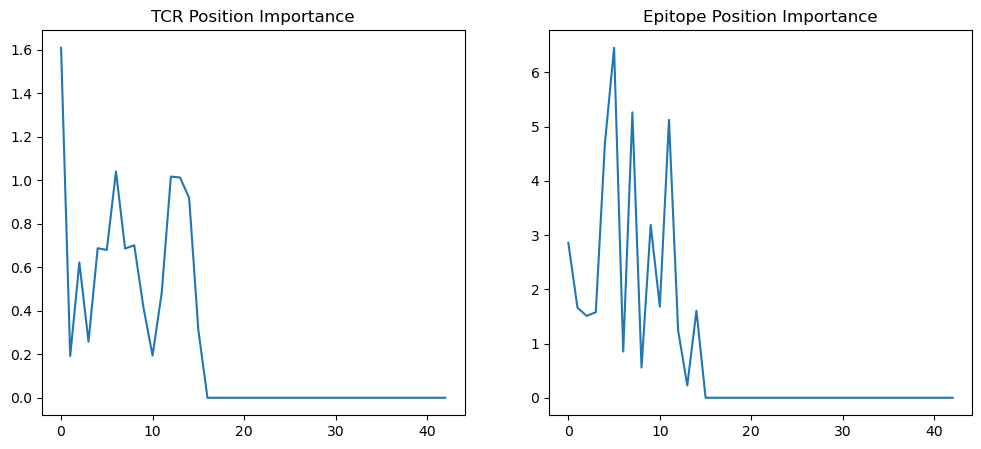

In [15]:
import matplotlib.pyplot as plt

# Split TCR and Epitope attributions
tcr_attr = attributions[:, 0, :, :].squeeze(0)      # (seq_len, embed_dim)
epitope_attr = attributions[:, 1, :, :].squeeze(0)

# Sum absolute attributions over embedding dimension
tcr_importance = tcr_attr.abs().sum(dim=-1).detach().cpu().numpy()
epitope_importance = epitope_attr.abs().sum(dim=-1).detach().cpu().numpy()

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tcr_importance)
plt.title("TCR Position Importance")

plt.subplot(1, 2, 2)
plt.plot(epitope_importance)
plt.title("Epitope Position Importance")

plt.show()


## Captum on v2-model

#### v2_mha_1024_res_more_features

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas as pd
import h5py
import torch
import numpy as np
import shap
import wandb
import os

class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout), # - Nochmals prüfen, ob wirklich notwendig vlt auslassen  
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        return x + self.block(x)


class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            #nn.Linear(input_dim, hidden_dim),
            #nn.BatchNorm1d(hidden_dim),
            #nn.ReLU(),
            #nn.Dropout(dropout),
            ResidualBlock(input_dim, dropout),
            nn.Linear(input_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(AttentionBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout) # Im Transformer Dropout ohne versuchen / Sequentiell ja () Anders Paper noch - wie sie es gmacht haben im AB 
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        attn_output, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

# class LazyTCR_Epitope_Dataset(torch.utils.data.Dataset):
#     def __init__(self, data_frame, tcr_embeddings, epitope_embeddings,
#                  trbv_dict, trbj_dict, mhc_dict):
#         self.data_frame = data_frame
#         self.tcr_embeddings = tcr_embeddings
#         self.epitope_embeddings = epitope_embeddings

#         # Dictionary-Zuweisung
#         self.trbv_dict = trbv_dict
#         self.trbj_dict = trbj_dict
#         self.mhc_dict = mhc_dict

#         # Berechne UNKNOWN-Indices
#         self.unknown_trbv_idx = len(trbv_dict)
#         self.unknown_trbj_idx = len(trbj_dict)
#         self.unknown_mhc_idx = len(mhc_dict)

#         self.data_frame["TRBV_Index"] = data_frame["TRBV"].map(trbv_dict).fillna(self.unknown_trbv_idx).astype(int)
#         self.data_frame["TRBJ_Index"] = data_frame["TRBJ"].map(trbj_dict).fillna(self.unknown_trbj_idx).astype(int)
#         self.data_frame["MHC_Index"] = data_frame["MHC"].map(mhc_dict).fillna(self.unknown_mhc_idx).astype(int)

#         # Sicherheit
#         assert self.data_frame["TRBV_Index"].max() < (self.unknown_trbv_idx + 1), "TRBV_Index out of range!"
#         assert self.data_frame["TRBJ_Index"].max() < (self.unknown_trbj_idx + 1), "TRBJ_Index out of range!"
#         assert self.data_frame["MHC_Index"].max() < (self.unknown_mhc_idx + 1), "MHC_Index out of range!"


#     def __getitem__(self, idx):
#         sample = self.data_frame.iloc[idx]
#         tcr_id = sample["TRB_CDR3"]
#         epitope_id = sample["Epitope"]
#         label = sample["Binding"]

#         tcr_embedding = self.tcr_embeddings[tcr_id][:]
#         epitope_embedding = self.epitope_embeddings[epitope_id][:]

#         return (
#             torch.tensor(tcr_embedding, dtype=torch.float32),
#             torch.tensor(epitope_embedding, dtype=torch.float32),
#             torch.tensor(sample["TRBV_Index"], dtype=torch.long),
#             torch.tensor(sample["TRBJ_Index"], dtype=torch.long),
#             torch.tensor(sample["MHC_Index"], dtype=torch.long),
#             torch.tensor(label, dtype=torch.float32)
#         )

#     def __len__(self):
#         return len(self.data_frame)


class LazyTCR_Epitope_Dataset(Dataset):
    def __init__(self, data_frame, tcr_embeddings, epitope_embeddings, trbv_dict, trbj_dict, mhc_dict):
        """
        Args:
            data_frame (pd.DataFrame): The dataframe containing sample metadata.
            tcr_embeddings (np.array): TCR embeddings (ordered).
            epitope_embeddings (np.array): Epitope embeddings (ordered).
            trbv_dict (dict): Mapping from TRBV genes to indices.
            trbj_dict (dict): Mapping from TRBJ genes to indices.
            mhc_dict (dict): Mapping from MHC alleles to indices.
        """
        self.data_frame = data_frame.reset_index(drop=True)

        # Build mapping from ID to embedding
        self.tcr_embeddings = {tcr_id: emb for tcr_id, emb in zip(data_frame["TRB_CDR3"], tcr_embeddings)}
        self.epitope_embeddings = {epi_id: emb for epi_id, emb in zip(data_frame["Epitope"], epitope_embeddings)}

        self.trbv_dict = trbv_dict
        self.trbj_dict = trbj_dict
        self.mhc_dict  = mhc_dict

        # Define unknown indices
        self.unknown_trbv_idx = len(trbv_dict)
        self.unknown_trbj_idx = len(trbj_dict)
        self.unknown_mhc_idx  = len(mhc_dict)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]

        tcr_id = sample["TRB_CDR3"]
        epitope_id = sample["Epitope"]
        label = sample["Binding"]

        # Get embeddings safely
        try:
            tcr_embedding = self.tcr_embeddings[tcr_id]
        except KeyError:
            raise ValueError(f"TCR ID {tcr_id} not found in tcr_embeddings dictionary.")
        
        try:
            epitope_embedding = self.epitope_embeddings[epitope_id]
        except KeyError:
            raise ValueError(f"Epitope ID {epitope_id} not found in epitope_embeddings dictionary.")

        # Map TRBV, TRBJ, MHC to index, default to unknown
        trbv_idx = self.trbv_dict.get(sample["TRBV"], self.unknown_trbv_idx)
        trbj_idx = self.trbj_dict.get(sample["TRBJ"], self.unknown_trbj_idx)
        mhc_idx  = self.mhc_dict.get(sample["MHC"],  self.unknown_mhc_idx)

        return (
            torch.tensor(tcr_embedding, dtype=torch.float32),
            torch.tensor(epitope_embedding, dtype=torch.float32),
            torch.tensor(trbv_idx, dtype=torch.long).unsqueeze(0),  # Embedding layers expect (batch, 1)
            torch.tensor(trbj_idx, dtype=torch.long).unsqueeze(0),
            torch.tensor(mhc_idx, dtype=torch.long).unsqueeze(0),
            torch.tensor(label, dtype=torch.float32)
        )


class TCR_Epitope_Transformer(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=2, max_tcr_length=20, max_epitope_length=15,
             dropout=0.1, classifier_hidden_dim=64,
             trbv_vocab_size=50, trbj_vocab_size=20, mhc_vocab_size=100):
        super(TCR_Epitope_Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.tcr_embedding = nn.Linear(1024, embed_dim)
        self.epitope_embedding = nn.Linear(1024, embed_dim)
        self.trbv_embed = nn.Embedding(trbv_vocab_size, embed_dim, padding_idx=trbv_vocab_size - 1)
        self.trbj_embed = nn.Embedding(trbj_vocab_size, embed_dim, padding_idx=trbj_vocab_size - 1)
        self.mhc_embed  = nn.Embedding(mhc_vocab_size,  embed_dim, padding_idx=mhc_vocab_size - 1)

        self.tcr_positional_encoding = nn.Parameter(torch.randn(1, max_tcr_length, embed_dim))
        self.epitope_positional_encoding = nn.Parameter(torch.randn(1, max_epitope_length, embed_dim))

        self.transformer_layers = nn.ModuleList([
            AttentionBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)
        ])

        #self.classifier_input_dim = 11392 
        self.classifier_input_dim = (max_tcr_length + max_epitope_length) * embed_dim + 3 * embed_dim

        self.classifier = Classifier(self.classifier_input_dim, classifier_hidden_dim, dropout)


    def forward(self, tcr, epitope, trbv, trbj, mhc):
        tcr_emb = self.tcr_embedding(tcr)
        epitope_emb = self.epitope_embedding(epitope)
        trbv_embed = self.trbv_embed(trbv).squeeze(1)
        trbj_embed = self.trbj_embed(trbj).squeeze(1)
        mhc_embed = self.mhc_embed(mhc).squeeze(1)

        # Create masks
        tcr_mask = (tcr.sum(dim=-1) == 0)
        epitope_mask = (epitope.sum(dim=-1) == 0)

        # Add positional encoding
        tcr_emb += self.tcr_positional_encoding[:, :tcr_emb.size(1), :]
        epitope_emb += self.epitope_positional_encoding[:, :epitope_emb.size(1), :]

        # Concatenate sequence and mask
        combined = torch.cat([tcr_emb, epitope_emb], dim=1)
        key_padding_mask = torch.cat([tcr_mask, epitope_mask], dim=1)

        for layer in self.transformer_layers:
            combined = layer(combined, key_padding_mask=key_padding_mask)

        # Flatten the combined sequences + embeddings
        flattened = combined.view(combined.size(0), -1)

        # Alle Merkmale (TCR, Epitope, MHC, TRBV, TRBJ) für den Klassifikator zusammenführen
        combined_features = torch.cat([flattened, trbv_embed, trbj_embed, mhc_embed], dim=1)

        output = self.classifier(combined_features).squeeze(1)
        return output

In [2]:
import torch.nn as nn

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, tcr, epitope, trbv, trbj, mhc):
        return self.model(tcr, epitope, trbv, trbj, mhc)


In [3]:

# ---------------- Load Data ----------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_path = "../../../../../data/splitted_datasets/allele/beta/train.tsv"
valid_path = "../../../../../data/splitted_datasets/allele/beta/validation.tsv"

train_epi_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_epitope_embeddings_final.h5"
train_tcr_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_tcr_embeddings_final.h5"

train_df = pd.read_csv(train_path, sep='\t')
valid_df = pd.read_csv(valid_path, sep='\t')

# load an amount n*2 of samples (n positives, n negatives)
n_samples = 4
binding_samples = train_df[train_df['Binding'] == 1].sample(n_samples, random_state=42)
non_binding_samples = train_df[train_df['Binding'] == 0].sample(n_samples, random_state=42)
selected_samples = pd.concat([binding_samples, non_binding_samples])
selected_tcrs = selected_samples['TRB_CDR3'].tolist()
selected_epitopes = selected_samples['Epitope'].tolist()

def load_embeddings(h5_path, keys):
    embeddings = []
    with h5py.File(h5_path, 'r') as f:
        for key in keys:
            if key in f:
                embeddings.append(f[key][:])
            else:
                raise ValueError(f"Key '{key}' not found in {h5_path}")
    return np.stack(embeddings)

tcr_embeddings = load_embeddings(train_tcr_emb_path, selected_tcrs)
epi_embeddings = load_embeddings(train_epi_emb_path, selected_epitopes)

# Convert to tensors
tcr_batch = torch.tensor(tcr_embeddings, dtype=torch.float32)
epitope_batch = torch.tensor(epi_embeddings, dtype=torch.float32)

/tmp/ipykernel_33008/1340836317.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  valid_df = pd.read_csv(valid_path, sep='\t')


In [4]:
trbv_dict = {v: i for i, v in enumerate(train_df["TRBV"].unique())}
trbj_dict = {v: i for i, v in enumerate(train_df["TRBJ"].unique())}
mhc_dict  = {v: i for i, v in enumerate(train_df["MHC"].unique())}

UNKNOWN_TRBV_IDX = len(trbv_dict)
UNKNOWN_TRBJ_IDX = len(trbj_dict)
UNKNOWN_MHC_IDX  = len(mhc_dict)

for df in [train_df, valid_df]:
    df["TRBV_Index"] = df["TRBV"].map(trbv_dict).fillna(UNKNOWN_TRBV_IDX).astype(int)
    df["TRBJ_Index"] = df["TRBJ"].map(trbj_dict).fillna(UNKNOWN_TRBJ_IDX).astype(int)
    df["MHC_Index"]  = df["MHC"].map(mhc_dict).fillna(UNKNOWN_MHC_IDX).astype(int)

# Vokabulargrößen bestimmen
trbv_vocab_size = UNKNOWN_TRBV_IDX + 1
trbj_vocab_size = UNKNOWN_TRBJ_IDX + 1
mhc_vocab_size  = UNKNOWN_MHC_IDX + 1

print(trbv_vocab_size)
print(trbj_vocab_size)
print(mhc_vocab_size)

trbv_dict = {v: i for i, v in enumerate(selected_samples["TRBV"].unique())}
trbj_dict = {v: i for i, v in enumerate(selected_samples["TRBJ"].unique())}
mhc_dict  = {v: i for i, v in enumerate(selected_samples["MHC"].unique())}


dataset = LazyTCR_Epitope_Dataset(selected_samples, tcr_embeddings, epi_embeddings,
                                  trbv_dict, trbj_dict, mhc_dict)


162
30
63


In [9]:
# Assume you have dataloader or dataset
sample = dataset[0]    # (tcr, epitope, trbv, trbj, mhc, label)
tcr_sample, epitope_sample, trbv_sample, trbj_sample, mhc_sample, label = sample

# Add batch dimension and fix types
tcr_sample = tcr_sample.unsqueeze(0).float().to(device)
epitope_sample = epitope_sample.unsqueeze(0).float().to(device)
trbv_sample = trbv_sample.unsqueeze(0).long().to(device)
trbj_sample = trbj_sample.unsqueeze(0).long().to(device)
mhc_sample = mhc_sample.unsqueeze(0).long().to(device)


In [6]:
run = wandb.init()
artifact = run.use_artifact('ba_cancerimmunotherapy/dataset-allele/Run_v1_mha_1024h_model:v21', type='model')
artifact_dir = artifact.download()
model_file = os.path.join(artifact_dir, os.listdir(artifact_dir)[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TCR_Epitope_Transformer(embed_dim=128, num_heads=8, 
num_layers=4, max_tcr_length=43, max_epitope_length=43,
             dropout=0.1, classifier_hidden_dim=64,
             trbv_vocab_size=trbv_vocab_size, 
             trbj_vocab_size=trbj_vocab_size, 
             mhc_vocab_size=mhc_vocab_size,
             ).to(device)
model.load_state_dict(torch.load(model_file, map_location=device))


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arina-frohofer (ba_cancerimmunotherapy). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact Run_v1_mha_1024h_model:v21, 994.82MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:6.2
/tmp/ipykernel_33008/1323064587.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any i

<All keys matched successfully>

In [29]:
model.tcr_embedding
model.trbv_embed

Embedding(162, 128, padding_idx=161)

In [12]:
from captum.attr import IntegratedGradients
# inputs = (
#     tcr_sample, 
#     epitope_sample, 
#     trbv_sample,     
#     trbj_sample,
#     mhc_sample
# )
inputs = (tcr_sample, epitope_sample)  # Only continuous inputs

additional_args = (trbv_sample, trbj_sample, mhc_sample)  # Categorical features separately


wrapped_model = ModelWrapper(model)

wrapped_model = wrapped_model.to(device)
wrapped_model.eval()


ig = IntegratedGradients(wrapped_model)

# attributions, delta = ig.attribute(
#     inputs,
#     target=None,
#     return_convergence_delta=True,
#     n_steps=50
# )
attributions, delta = ig.attribute(
    inputs,
    target=None,
    additional_forward_args=additional_args,
    return_convergence_delta=True,
    n_steps=50
)


print("Attributions returned:", type(attributions), len(attributions))
for i, attr in enumerate(attributions):
    print(f"Attribution {i}: shape {attr.shape}")




Attributions returned: <class 'tuple'> 2
Attribution 0: shape torch.Size([1, 43, 1024])
Attribution 1: shape torch.Size([1, 43, 1024])


In [ ]:
def plot_categorical_attribution(attr, title):
    attr = attr.squeeze(0).detach().cpu().numpy()
    summed_attr = np.sum(np.abs(attr), axis=-1)  # Sum over embedding dimension if needed

    plt.figure(figsize=(6, 3))
    plt.bar(range(len(summed_attr)), summed_attr)
    plt.title(title)
    plt.xlabel("Embedding Feature Index")
    plt.ylabel("Importance (Summed Attribution)")
    plt.tight_layout()
    plt.show()
plot_categorical_attribution(attributions[2], "TRBV Embedding Attribution")
plot_categorical_attribution(attributions[3], "TRBJ Embedding Attribution")
plot_categorical_attribution(attributions[4], "MHC Embedding Attribution")


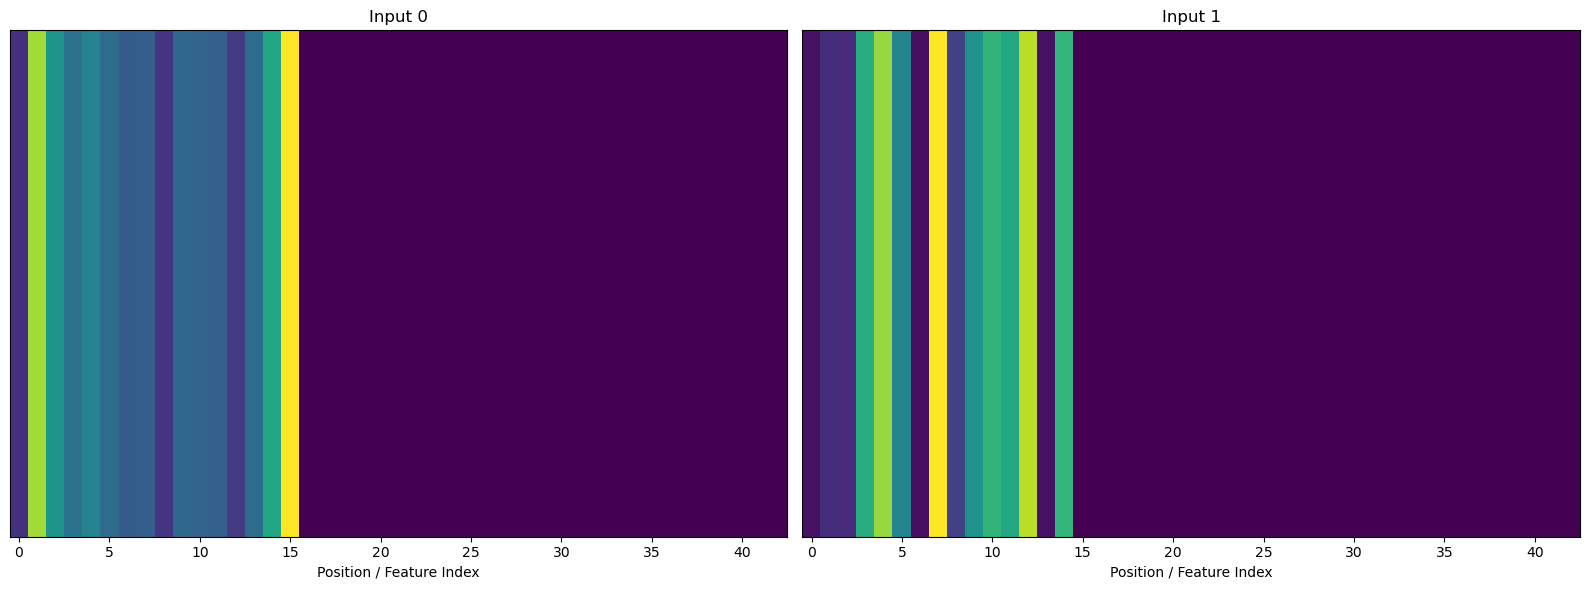

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attributions(attributions, titles=None, figsize=(16, 6)):
    """
    Plot attributions from Integrated Gradients.
    
    Args:
        attributions (tuple of tensors): attribution tensors (tcr_attr, epitope_attr).
        titles (list): titles for subplots.
        figsize (tuple): size of the whole figure.
    """
    num_inputs = len(attributions)
    if titles is None:
        titles = [f"Input {i}" for i in range(num_inputs)]
    
    fig, axes = plt.subplots(1, num_inputs, figsize=figsize)

    if num_inputs == 1:
        axes = [axes]  # Make it iterable if only one plot

    for i, attr in enumerate(attributions):
        attr = attr.squeeze(0).detach().cpu().numpy()  # Remove batch dimension, move to CPU
        summed_attr = np.sum(np.abs(attr), axis=-1)    # Sum across feature dimension if necessary

        axes[i].imshow(summed_attr[np.newaxis, :], cmap='viridis', aspect='auto')
        axes[i].set_title(titles[i])
        axes[i].set_yticks([])
        axes[i].set_xlabel("Position / Feature Index")

    plt.tight_layout()
    plt.show()
plot_attributions(attributions)

## Captum on v3

#### v3_mha_1024_res_php_pe.py

In [ ]:
#import like this or read the model below

import sys
import os

# Get the absolute path of 'TCRpeg' and add it to sys.path
model_path = os.path.abspath("../../../models/morning_stars_v1/beta")
sys.path.append(model_path)

from v3_mha_1024_res_php_pe import TCR_Epitope_Transformer, LazyTCR_Epitope_Descriptor_Dataset


In [1]:
import torch
import torch.nn as nn
import h5py
import math
import numpy as np
import pandas as pd

class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            ResidualBlock(hidden_dim, dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(AttentionBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):
        attn_output, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

class PeriodicEmbedding(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = input_dim * 2

    def forward(self, x):
        # Erwartet (batch_size, input_dim)
        div_term = torch.exp(
            torch.arange(0, self.input_dim, device=x.device, dtype=x.dtype) *
            -(np.log(10000.0) / self.input_dim)
        )  # (input_dim,)

        pe = torch.cat([torch.sin(x * div_term), torch.cos(x * div_term)], dim=-1)
        return pe

class LazyTCR_Epitope_Descriptor_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, tcr_embeddings, epitope_embeddings, physchem_h5_path):
        self.data_frame = data_frame
        self.tcr_embeddings = tcr_embeddings
        self.epitope_embeddings = epitope_embeddings
        self.physchem_data = physchem_h5_path

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]
        tcr_id = sample["TRB_CDR3"]
        epitope_id = sample["Epitope"]
        label = sample["Binding"]
        phys_idx = sample["physchem_index"]

        # Use dict lookup here
        tcr_embedding = self.tcr_embeddings[tcr_id]
        epitope_embedding = self.epitope_embeddings[epitope_id]
        tcr_physchem = self.physchem_data["tcr_encoded"][phys_idx]
        epi_physchem = self.physchem_data["epi_encoded"][phys_idx]

        return (
            torch.tensor(tcr_embedding, dtype=torch.float32),
            torch.tensor(epitope_embedding, dtype=torch.float32),
            torch.tensor(tcr_physchem, dtype=torch.float32),
            torch.tensor(epi_physchem, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32),
        )

    # def __getitem__(self, idx):
    #     sample = self.data_frame.iloc[idx]
    #     tcr_id = sample["TRB_CDR3"]
    #     epitope_id = sample["Epitope"]
    #     label = sample["Binding"]
    #     phys_idx = sample["physchem_index"]  # <- RICHTIG
    
    #     tcr_embedding = self.tcr_embeddings[tcr_id][:]
    #     epitope_embedding = self.epitope_embeddings[epitope_id][:]
    #     tcr_physchem = self.physchem_data["tcr_encoded"][phys_idx]
    #     epi_physchem = self.physchem_data["epi_encoded"][phys_idx]
    
    #     return (
    #         torch.tensor(tcr_embedding, dtype=torch.float32),
    #         torch.tensor(epitope_embedding, dtype=torch.float32),
    #         torch.tensor(tcr_physchem, dtype=torch.float32),
    #         torch.tensor(epi_physchem, dtype=torch.float32),
    #         torch.tensor(label, dtype=torch.float32),
    #     )

class TCR_Epitope_Transformer(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=2, max_tcr_length=43, max_epitope_length=43,
                 dropout=0.1, classifier_hidden_dim=64, physchem_dim=10):
        super(TCR_Epitope_Transformer, self).__init__()

        self.embed_dim = embed_dim
        self.tcr_embedding = nn.Linear(1024, embed_dim)
        self.epitope_embedding = nn.Linear(1024, embed_dim)

        self.tcr_positional_encoding = nn.Parameter(torch.randn(1, max_tcr_length, embed_dim))
        self.epitope_positional_encoding = nn.Parameter(torch.randn(1, max_epitope_length, embed_dim))

        self.transformer_layers = nn.ModuleList([
            AttentionBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)
        ])

        self.physchem_dim = physchem_dim
        self.tcr_physchem_embed = PeriodicEmbedding(physchem_dim)
        self.epi_physchem_embed = PeriodicEmbedding(physchem_dim)

        self.classifier_input_dim = embed_dim * (max_tcr_length + max_epitope_length) + self.tcr_physchem_embed.output_dim * 2

        self.classifier = Classifier(self.classifier_input_dim, classifier_hidden_dim, dropout)

    def forward(self, tcr, epitope, tcr_physchem=None, epi_physchem=None):
        tcr_emb = self.tcr_embedding(tcr)
        epitope_emb = self.epitope_embedding(epitope)
    
        # Create masks
        tcr_mask = (tcr.sum(dim=-1) == 0)
        epitope_mask = (epitope.sum(dim=-1) == 0)
    
        # Add positional encoding
        tcr_emb += self.tcr_positional_encoding[:, :tcr_emb.size(1), :]
        epitope_emb += self.epitope_positional_encoding[:, :epitope_emb.size(1), :]
    
        # Concatenate sequence and mask
        combined = torch.cat([tcr_emb, epitope_emb], dim=1)
        key_padding_mask = torch.cat([tcr_mask, epitope_mask], dim=1)
    
        for layer in self.transformer_layers:
            combined = layer(combined, key_padding_mask=key_padding_mask)
    
        # flattening + classifier
        flattened = combined.view(combined.size(0), -1)  # [batch_size, total_seq_len * embed_dim]
    
        # Physikochemie anhängen
        if tcr_physchem is not None and epi_physchem is not None:
            tcr_physchem = self.tcr_physchem_embed(tcr_physchem)
            epi_physchem = self.epi_physchem_embed(epi_physchem)
            flattened = torch.cat([flattened, tcr_physchem, epi_physchem], dim=1)
    
        output = self.classifier(flattened).squeeze(1)
        return output


In [3]:
import torch
import numpy as np
# ---------------- Load Data ----------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_path = "../../../../../data/splitted_datasets/allele/beta/train.tsv"
valid_path = "../../../../../data/splitted_datasets/allele/beta/validation.tsv"

train_epi_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_epitope_embeddings_final.h5"
train_tcr_emb_path = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_train_tcr_embeddings_final.h5"

train_df = pd.read_csv(train_path, sep='\t')
valid_df = pd.read_csv(valid_path, sep='\t', low_memory=False)

physchem_path =  "../../../../../data/physico/descriptor_encoded_physchem.h5"
physchem_file = h5py.File(physchem_path, 'r')

physchem_map = pd.read_csv("../../../../../data/physico/descriptor_encoded_physchem_mapping.tsv", sep="\t")
train_df = pd.merge(train_df, physchem_map, on=["TRB_CDR3", "Epitope"], how="left")
# valid_df = pd.merge(valid_df, physchem_map, on=["TRB_CDR3", "Epitope"], how="left")


def get_physchem_vectors_by_physidx(physchem_file, indices, key):
    """
    Fetch vectors from an HDF5 dataset with keys like 'tcr_encoded' or 'epi_encoded',
    using a list of integer indices.

    Parameters:
        physchem_file: opened h5py.File
        indices: list or array of integers (phys_idx values)
        key: str, either 'tcr_encoded' or 'epi_encoded'

    Returns:
        np.array of shape [len(indices), feature_dim]
    """
    dataset = physchem_file[key]
    return np.stack([dataset[i] for i in indices])

# load an amount n*2 of samples (n positives, n negatives)
n_samples = 25
binding_samples = train_df[train_df['Binding'] == 1].sample(n_samples, random_state=42)
non_binding_samples = train_df[train_df['Binding'] == 0].sample(n_samples, random_state=42)
selected_samples = pd.concat([binding_samples, non_binding_samples])
selected_tcrs = selected_samples['TRB_CDR3'].tolist()
selected_epitopes = selected_samples['Epitope'].tolist()

# Subset merged train_df to match the selected samples
selected_physchem_df = train_df.set_index(['TRB_CDR3', 'Epitope']).loc[list(zip(selected_tcrs, selected_epitopes))]

# Get the phys_idx for each sample
phys_indices = selected_physchem_df['physchem_index'].values

# Extract from h5 file
tcr_physchem_sample = get_physchem_vectors_by_physidx(physchem_file, phys_indices, key='tcr_encoded')
epi_physchem_sample = get_physchem_vectors_by_physidx(physchem_file, phys_indices, key='epi_encoded')

# Convert to tensors
tcr_physchem_tensor = torch.tensor(tcr_physchem_sample, dtype=torch.float32).to(device)
epi_physchem_tensor = torch.tensor(epi_physchem_sample, dtype=torch.float32).to(device)


# def load_embeddings(h5_path, keys):
#     embeddings = []
#     with h5py.File(h5_path, 'r') as f:
#         for key in keys:
#             if key in f:
#                 embeddings.append(f[key][:])
#             else:
#                 raise ValueError(f"Key '{key}' not found in {h5_path}")
#     return np.stack(embeddings)

def load_embeddings(h5_path, keys):
    embeddings = {}
    with h5py.File(h5_path, 'r') as f:
        for key in keys:
            if key in f:
                embeddings[key] = f[key][:]
            else:
                raise ValueError(f"Key '{key}' not found in {h5_path}")
    return embeddings


tcr_embeddings = load_embeddings(train_tcr_emb_path, selected_tcrs)
epi_embeddings = load_embeddings(train_epi_emb_path, selected_epitopes)

train_dataset = LazyTCR_Epitope_Descriptor_Dataset(selected_samples, tcr_embeddings, epi_embeddings, physchem_file)

print("TCR physchem shape:", tcr_physchem_tensor.shape)   # Expected: [50, 102]
print("Epitope physchem shape:", epi_physchem_tensor.shape)  # Expected: [50, 102]

background_data = [tcr_physchem_tensor[:1], epi_physchem_tensor[:1]]  # 1-sample baseline
sample_data = [tcr_physchem_tensor, epi_physchem_tensor]              # 50 samples


TCR physchem shape: torch.Size([50, 102])
Epitope physchem shape: torch.Size([50, 102])


In [4]:
import wandb
import os

run = wandb.init()
artifact = run.use_artifact('ba_cancerimmunotherapy/dataset-allele/Run_v3_mha_resh_model:v3', type='model')
artifact_dir = artifact.download()
model_file = os.path.join(artifact_dir, os.listdir(artifact_dir)[0])

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arina-frohofer (ba_cancerimmunotherapy). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [14]:
checkpoint = torch.load(model_file, map_location=device)
for k, v in checkpoint.items():
    print(f"{k}: {v.shape}")

tcr_positional_encoding: torch.Size([1, 43, 128])
epitope_positional_encoding: torch.Size([1, 43, 128])
tcr_embedding.weight: torch.Size([128, 1024])
tcr_embedding.bias: torch.Size([128])
epitope_embedding.weight: torch.Size([128, 1024])
epitope_embedding.bias: torch.Size([128])
transformer_layers.0.attn.in_proj_weight: torch.Size([384, 128])
transformer_layers.0.attn.in_proj_bias: torch.Size([384])
transformer_layers.0.attn.out_proj.weight: torch.Size([128, 128])
transformer_layers.0.attn.out_proj.bias: torch.Size([128])
transformer_layers.0.norm1.weight: torch.Size([128])
transformer_layers.0.norm1.bias: torch.Size([128])
transformer_layers.0.ff.0.weight: torch.Size([512, 128])
transformer_layers.0.ff.0.bias: torch.Size([512])
transformer_layers.0.ff.3.weight: torch.Size([128, 512])
transformer_layers.0.ff.3.bias: torch.Size([128])
transformer_layers.0.norm2.weight: torch.Size([128])
transformer_layers.0.norm2.bias: torch.Size([128])
classifier.model.0.weight: torch.Size([64, 11416])

/tmp/ipykernel_79082/2553021575.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file, map_location=device)


In [5]:
model = TCR_Epitope_Transformer(embed_dim=128, num_heads=4, 
num_layers=1, max_tcr_length=43, max_epitope_length=43,
             dropout=0.1, classifier_hidden_dim=64, physchem_dim=102
             ).to(device)

model.load_state_dict(torch.load(model_file, map_location=device))

/tmp/ipykernel_86598/4122286243.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=device))


<All keys matched successfully>

In [6]:
def compute_physchem_feature_importance(model, dataset, device, baseline="zero"):
    model.eval()
    importances = {
        "tcr": np.zeros(102),
        "epitope": np.zeros(102)
    }

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for batch in dataloader:
            # tcr_emb = batch['tcr_emb'].to(device)
            # epi_emb = batch['epitope_emb'].to(device)
            # tcr_phys = batch['tcr_physchem'].to(device)
            # epi_phys = batch['epitope_physchem'].to(device)

            tcr_emb, epi_emb, tcr_phys, epi_phys, _ = [x.to(device) for x in batch]

            original_output = model(tcr_emb, epi_emb, tcr_phys, epi_phys).item()

            for i in range(102):  # TCR features
                perturbed = tcr_phys.clone()
                if baseline == "zero":
                    perturbed[:, i] = 0
                elif baseline == "mean":
                    perturbed[:, i] = tcr_phys[:, i].mean()
                output = model(tcr_emb, epi_emb, perturbed, epi_phys).item()
                importances["tcr"][i] += abs(original_output - output)

            for i in range(102):  # Epitope features
                perturbed = epi_phys.clone()
                if baseline == "zero":
                    perturbed[:, i] = 0
                elif baseline == "mean":
                    perturbed[:, i] = epi_phys[:, i].mean()
                output = model(tcr_emb, epi_emb, tcr_phys, perturbed).item()
                importances["epitope"][i] += abs(original_output - output)

    # Normalize
    importances["tcr"] /= len(dataset)
    importances["epitope"] /= len(dataset)

    return importances


In [7]:
importances = compute_physchem_feature_importance(model, train_dataset, device)


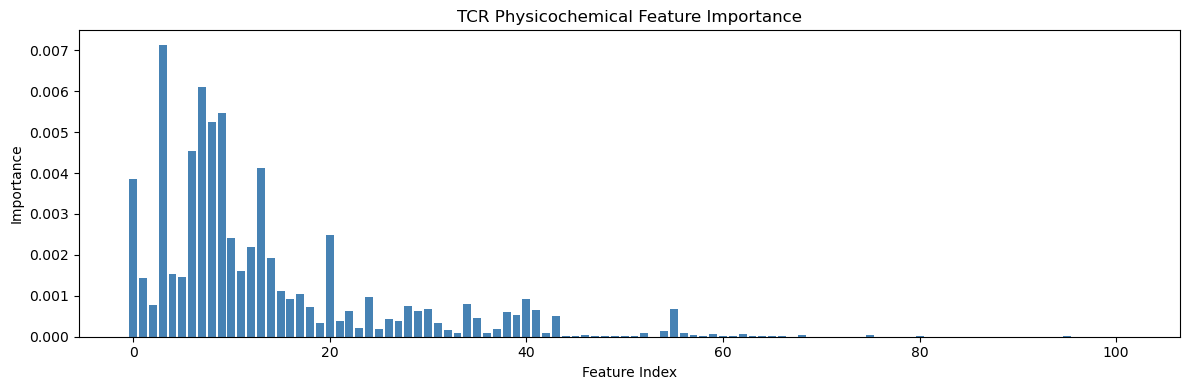

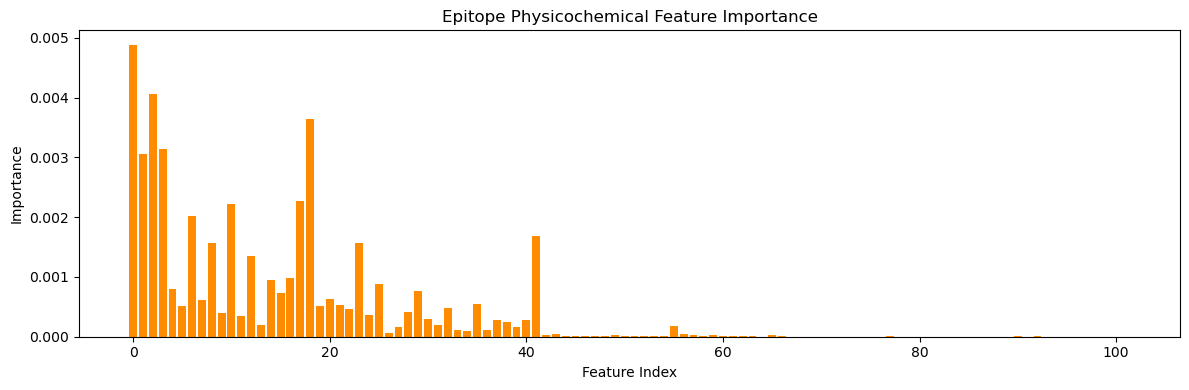

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Sort importances (optional, for better visuals)
tcr_importance = importances["tcr"]
epi_importance = importances["epitope"]

# Plot TCR physchem importances
plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(tcr_importance)), tcr_importance, color='steelblue')
plt.title("TCR Physicochemical Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Plot Epitope physchem importances
plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(epi_importance)), epi_importance, color='darkorange')
plt.title("Epitope Physicochemical Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


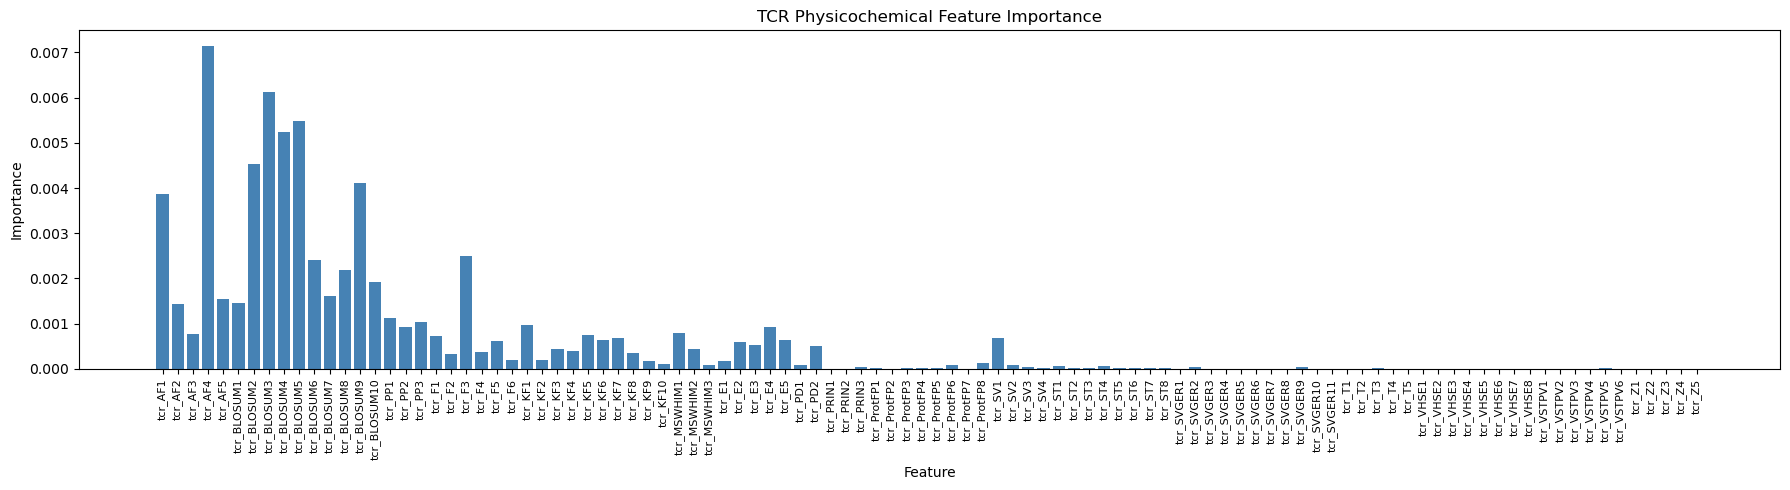

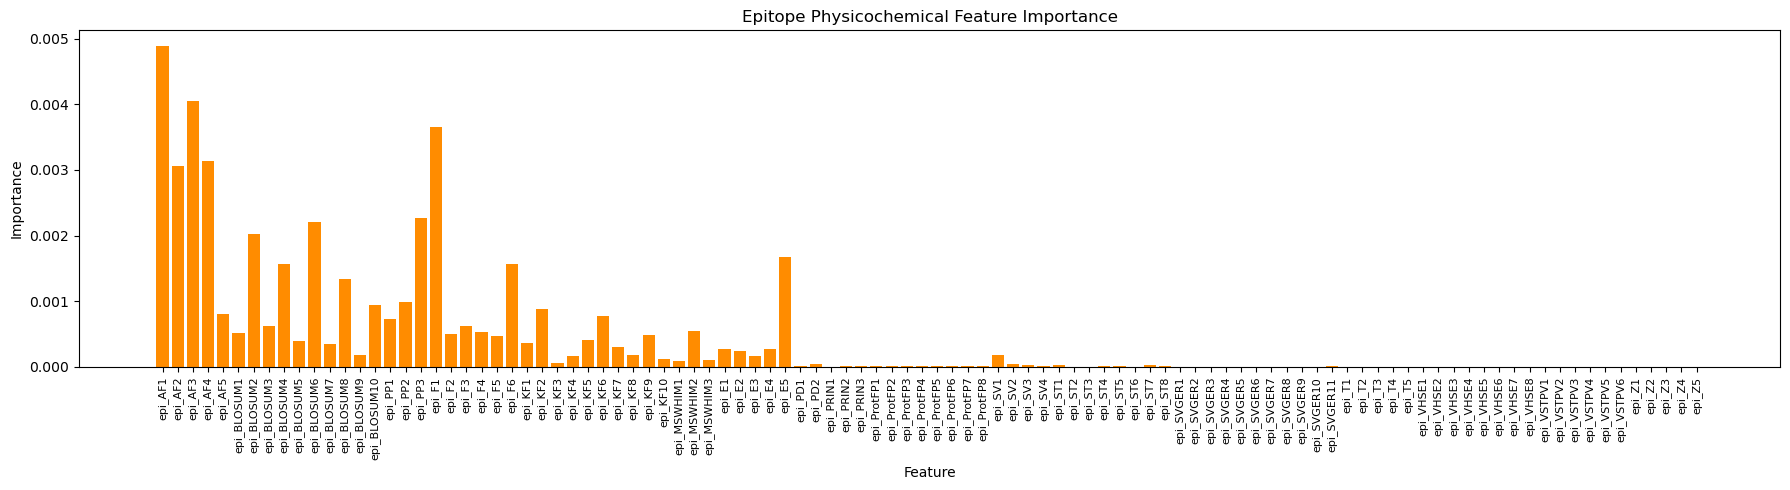

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names from desc_df
tcr_feature_names = [col for col in desc_df.columns if col.startswith("tcr_")]
epi_feature_names = [col for col in desc_df.columns if col.startswith("epi_")]

# Make sure they align with the importance array size
assert len(tcr_feature_names) == 102
assert len(epi_feature_names) == 102

# Access the importance arrays
tcr_importance = importances["tcr"]
epi_importance = importances["epitope"]

# Plot TCR feature importances
plt.figure(figsize=(18, 5))
plt.bar(np.arange(len(tcr_importance)), tcr_importance, color='steelblue')
plt.xticks(ticks=np.arange(len(tcr_feature_names)), labels=tcr_feature_names, rotation=90, fontsize=8)
plt.title("TCR Physicochemical Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Plot Epitope feature importances
plt.figure(figsize=(18, 5))
plt.bar(np.arange(len(epi_importance)), epi_importance, color='darkorange')
plt.xticks(ticks=np.arange(len(epi_feature_names)), labels=epi_feature_names, rotation=90, fontsize=8)
plt.title("Epitope Physicochemical Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


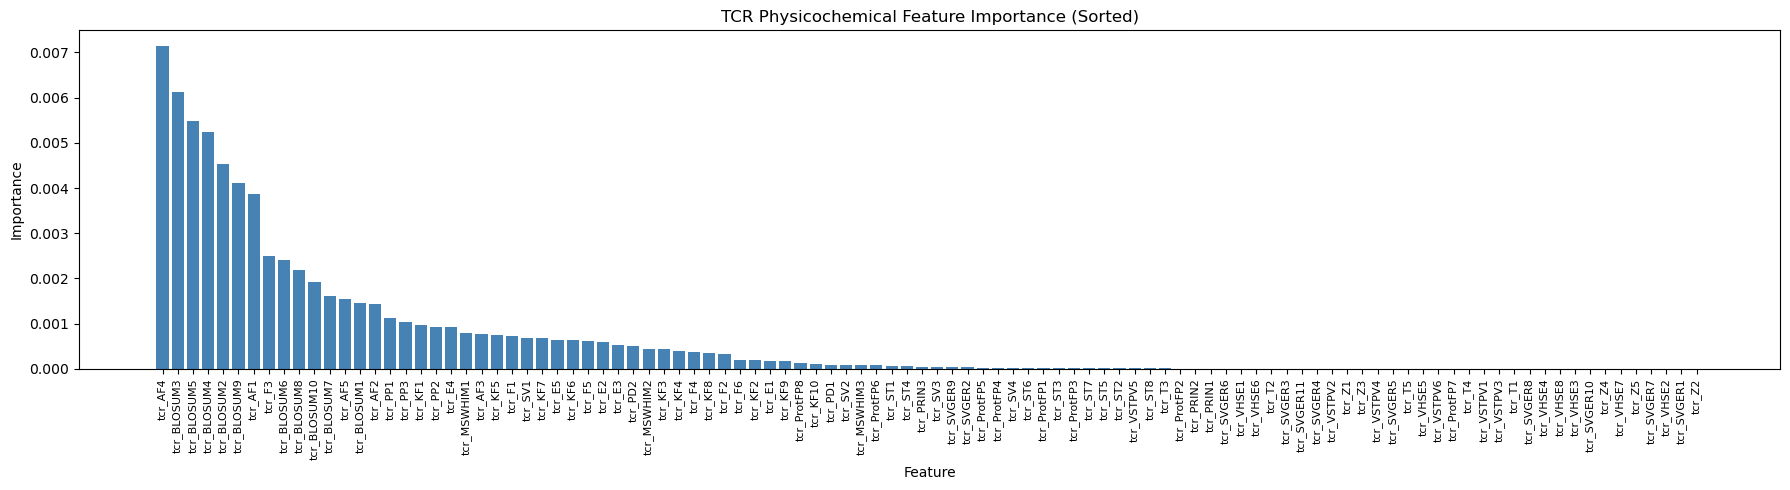

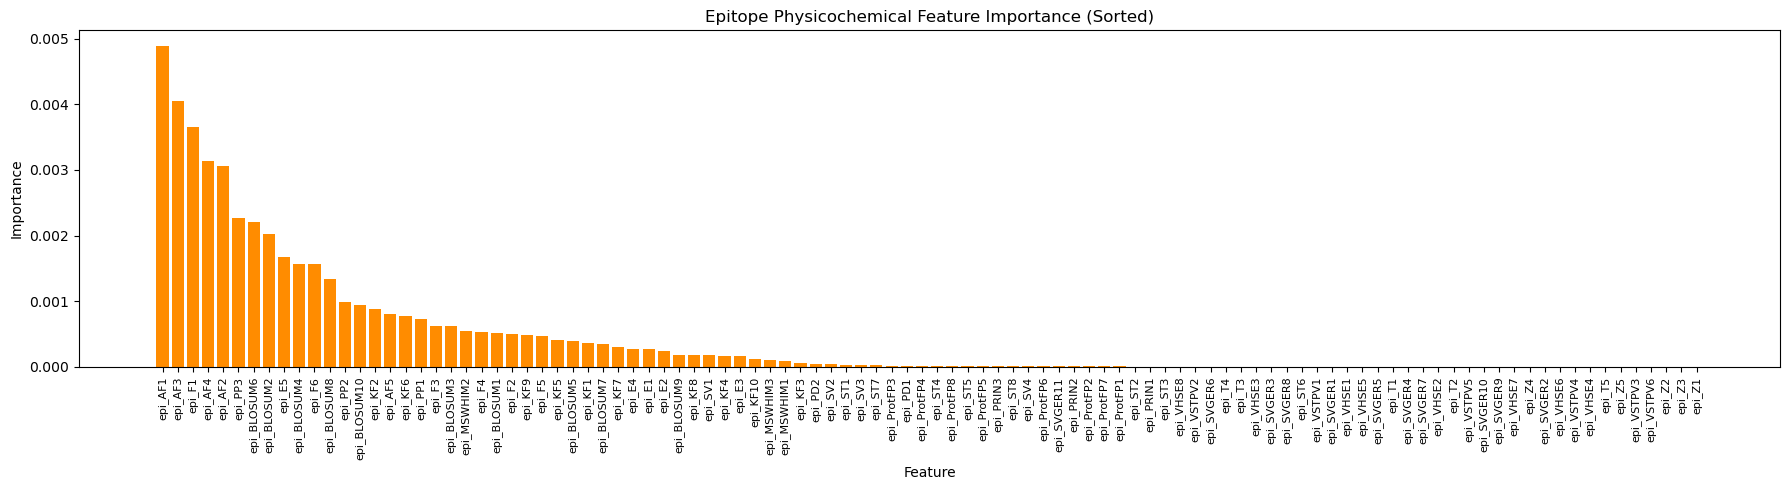

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Sort TCR importance and feature names
tcr_sorted_indices = np.argsort(-tcr_importance)  # Negative for descending
tcr_sorted_importance = tcr_importance[tcr_sorted_indices]
tcr_sorted_names = [tcr_feature_names[i] for i in tcr_sorted_indices]

# Plot sorted TCR importances
plt.figure(figsize=(18, 5))
plt.bar(np.arange(len(tcr_sorted_importance)), tcr_sorted_importance, color='steelblue')
plt.xticks(ticks=np.arange(len(tcr_sorted_names)), labels=tcr_sorted_names, rotation=90, fontsize=8)
plt.title("TCR Physicochemical Feature Importance (Sorted)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Sort Epitope importance and feature names
epi_sorted_indices = np.argsort(-epi_importance)
epi_sorted_importance = epi_importance[epi_sorted_indices]
epi_sorted_names = [epi_feature_names[i] for i in epi_sorted_indices]

# Plot sorted Epitope importances
plt.figure(figsize=(18, 5))
plt.bar(np.arange(len(epi_sorted_importance)), epi_sorted_importance, color='darkorange')
plt.xticks(ticks=np.arange(len(epi_sorted_names)), labels=epi_sorted_names, rotation=90, fontsize=8)
plt.title("Epitope Physicochemical Feature Importance (Sorted)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


### some checks on physico

In [ ]:
import h5py
import numpy as np

# Path to your HDF5 file
hdf5_path = "../../../../../data/physico/descriptor_encoded_physchem.h5"

# Open the HDF5 file in read mode
with h5py.File(hdf5_path, "r") as h5f:
    print("Datasets in the file:")
    for key in h5f.keys():
        data = h5f[key]
        print(f" - {key}: shape={data.shape}, dtype={data.dtype}")
        
    # Optional: load datasets to inspect contents
    tcr_encoded = h5f["tcr_encoded"][:]
    epi_encoded = h5f["epi_encoded"][:]
    binding = h5f["binding"][:]
    
    # print("\nSample data:")
    # print("tcr_encoded[0]:", tcr_encoded[0])
    # print("epi_encoded[0]:", epi_encoded[0])
    # print("binding[0]:", binding[0])


Datasets in the file:
 - binding: shape=(993078,), dtype=int64
 - epi_encoded: shape=(993078, 102), dtype=float64
 - tcr_encoded: shape=(993078, 102), dtype=float64

Sample data:
tcr_encoded[0]: [ 3.61664356e+00 -1.31394417e+00  1.19261033e+00 -4.56278865e+00
  6.53149528e-01  1.54276456e+00 -6.66290677e+00 -7.96043663e-01
 -1.85348714e+00 -2.29823471e+00  4.80538331e-01 -2.53749648e+00
  2.23740811e+00 -1.60822272e+00 -2.75608320e+00  2.35100647e+00
  4.68973577e+00  3.49637495e+00  3.32848543e+00 -1.05781929e+00
 -6.16728354e-01 -7.45365619e-01  1.10411057e+00  1.01446224e+00
 -1.64966168e+00  7.84596956e-01 -1.07578960e+00 -1.14300867e+00
  3.59310072e+00  4.02225851e-01  2.91112617e+00  6.12372801e-01
  1.84426807e-01  1.00376126e+00 -4.14976587e+00  2.40869021e-02
  5.20974596e+00 -2.13461468e+00 -5.44160485e+00 -5.44460665e+00
 -2.61083837e+01 -7.35526189e-01  3.16585060e+00 -5.18986022e+00
  1.08606240e+00  1.46855786e+00  9.52244565e-01  1.57472893e+00
  1.43075618e+00 -7.02243

In [ ]:
train_file_path = "../../../../../data/splitted_datasets/allele/beta/train.tsv"

train_data = pd.read_csv(train_file_path, sep="\t")
# val_data = pd.read_csv(val_file_path, sep="\t")

physchem_map = pd.read_csv("../../../../../data/physico/descriptor_encoded_physchem_mapping.tsv", sep="\t")

In [5]:
physchem_map = pd.read_csv("../../../../../data/physico/descriptor_encoded_physchem_mapping.tsv", sep="\t")
physchem_map.head()

,TRB_CDR3,Epitope,physchem_index
0,CAASQNTEAFF,ILDTAGKEEY,0
1,CASSLWEKLAKNIQYF,RQWGPDPAAV,1
2,CASSAGGGVETQYF,RAQAPPPSW,2
3,CASSQEFVGAVLDTQYF,TLREIRRYQK,3
4,CASRTRGGTLIEQYF,IPLTEEAEL,4


In [9]:
import pandas as pd
import numpy as np
import json
from peptides import Peptide
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import wandb
import joblib



# --- Dateipfade definieren ---
path_beta_train = "../../../../../data/splitted_datasets/allele/beta/train.tsv"

# --- Daten laden ---

df_beta_train = pd.read_csv(path_beta_train, sep="\t", index_col=False)

# --- Relevante Spalten extrahieren ---
df_physchem = df_beta_train[["TRB_CDR3", "Epitope", "Binding"]].dropna()

# --- Deskriptoren extrahieren ---
def get_descriptors(seq):
    try:
        return Peptide(seq).descriptors()
    except:
        return {}


tcr_desc = df_physchem["TRB_CDR3"].apply(get_descriptors)

epi_desc = df_physchem["Epitope"].apply(get_descriptors)

# --- Kombinieren & Label anhängen ---
tcr_df = pd.DataFrame(tcr_desc.tolist()).add_prefix("tcr_")
epi_df = pd.DataFrame(epi_desc.tolist()).add_prefix("epi_")
desc_df = pd.concat([tcr_df, epi_df], axis=1)
desc_df["label"] = df_physchem["Binding"].values

In [10]:
desc_df.head()

,tcr_AF1,tcr_AF2,tcr_AF3,tcr_AF4,tcr_AF5,tcr_BLOSUM1,tcr_BLOSUM2,tcr_BLOSUM3,tcr_BLOSUM4,tcr_BLOSUM5,...,epi_VSTPV3,epi_VSTPV4,epi_VSTPV5,epi_VSTPV6,epi_Z1,epi_Z2,epi_Z3,epi_Z4,epi_Z5,label
0,0.116623,0.107142,-0.664915,-0.202693,-0.773033,0.163750,0.355625,-0.004375,0.140000,0.063750,...,0.873333,-0.120000,-0.292222,-0.190000,-1.600000,-1.887778,-0.216667,-0.367778,-0.067778,0
1,-0.353990,0.614071,0.038913,0.396322,0.154959,0.087059,-0.024118,0.442353,0.209412,-0.147059,...,0.752222,-0.386667,-0.404444,-0.460000,-1.313333,-1.450000,-0.264444,0.102222,0.783333,0
2,-0.449971,0.126705,-0.649627,0.545306,-0.315661,-0.208000,-0.359333,0.112667,0.168667,0.112667,...,0.873333,-0.120000,-0.292222,-0.190000,-1.600000,-1.887778,-0.216667,-0.367778,-0.067778,0
3,-0.407534,0.178883,-0.733281,0.354487,-0.543702,-0.087857,-0.133571,0.369286,0.005714,-0.006429,...,0.273333,-0.100000,0.223333,0.245556,-0.510000,0.527778,0.363333,-0.024444,-0.263333,0
4,-0.153087,0.078931,-0.513032,0.447260,-0.358088,0.275000,-0.159375,0.235000,0.161250,0.051250,...,0.497222,-0.150000,-0.432222,-0.352778,-2.537778,-0.733333,-0.138889,0.045000,0.142778,0


In [13]:
desc_df.columns

Index(['tcr_AF1', 'tcr_AF2', 'tcr_AF3', 'tcr_AF4', 'tcr_AF5', 'tcr_BLOSUM1',
       'tcr_BLOSUM2', 'tcr_BLOSUM3', 'tcr_BLOSUM4', 'tcr_BLOSUM5',
       ...
       'epi_VSTPV3', 'epi_VSTPV4', 'epi_VSTPV5', 'epi_VSTPV6', 'epi_Z1',
       'epi_Z2', 'epi_Z3', 'epi_Z4', 'epi_Z5', 'label'],
      dtype='object', length=205)

In [11]:
tcr_desc.head()

0    {'AF1': 0.11662331749999999, 'AF2': 0.10714156...
1    {'AF1': -0.353989505882353, 'AF2': 0.614071150...
2    {'AF1': -0.44997075266666664, 'AF2': 0.1267049...
3    {'AF1': -0.4075337807142857, 'AF2': 0.17888284...
4    {'AF1': -0.153086564375, 'AF2': 0.078931039375...
Name: TRB_CDR3, dtype: object

In [12]:
# Convert the Series of dictionaries into a DataFrame (each key becomes a column)
tcrs_df = pd.json_normalize(tcr_desc)

# Save to CSV
tcrs_df.to_csv("tcr_descriptors.csv", index=False)

# Convert the Series of dictionaries into a DataFrame (each key becomes a column)
epitope_df = pd.json_normalize(epi_desc)

# Save to CSV
epitope_df.to_csv("epi_descriptors.csv", index=False)

### some check on validatin file

In [6]:
import pandas as pd

valid_path = "../../../../../data/splitted_datasets/allele/beta/validation.tsv"
df_sample = pd.read_csv(valid_path, sep='\t', nrows=5)
print(df_sample.columns)


Index(['TRB_CDR3', 'Epitope',
       'TCR_name\tTRAV\tTRAJ\tTRA_CDR3\tTRBV\tTRBJ\tTRB_CDR3\tTRB_leader\tTRAC\tTRBC\tLinker\tLink_order\tTRA_5_prime_seq\tTRA_3_prime_seq\tTRB_5_prime_seq\tTRB_3_prime_seq\tEpitope\tMHC\tMHC class',
       'TRBC', 'TRBV', 'TRBJ', 'MHC', 'TCR_name', 'Binding', 'task', 'source',
       'task_predicted'],
      dtype='object')


In [7]:
col_name = df_sample.columns[7]  # 8th column
df_full = pd.read_csv(valid_path, sep='\t', usecols=[col_name])

# Get type info
types = df_full[col_name].map(type).value_counts()
print("Data types in column 7:", types)



Data types in column 7: TCR_name
<class 'str'>    131072
<class 'int'>     55879
Name: count, dtype: int64


/tmp/ipykernel_74266/3295248275.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(valid_path, sep='\t', usecols=[col_name])
